<a href="https://colab.research.google.com/github/denden26/My-Python-Project/blob/main/Customer_Lifetime_Value_Ecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predicting customer lifetime value and future purchases**

Dalam kebanyakan kasus, nilai perusahaan adalah keuntungan dari pelanggan yang ada dan pelanggan masa depan (alias Ekuitas Pelanggan). Penelitian yang dilakukan oleh Frederick Reichheld dari Bain & Company (penemu skor promotor bersih) menunjukkan peningkatan tingkat retensi pelanggan sebesar 5% meningkatkan keuntungan sebesar 25% hingga 95% (Reichheld 2001).

Dimungkinkan untuk menghitung Ekuitas Pelanggan (CE) karena Nilai Customer Lifetime Value (CLV) dapat diukur dengan tingkat presisi yang wajar.

CLV adalah nilai sekarang dari arus kas masa depan (bersih) yang terkait dengan pelanggan (Gupta dan Lehmann 2003). Ini adalah konsep berwawasan ke depan, jangan disamakan dengan profitabilitas pelanggan bersejarah.

Tidak semua pelanggan sama pentingnya bagi perusahaan. Mempertahankan hubungan jangka panjang dengan mereka semua (terutama para pembuat kerugian) tidak optimal karena pada akhirnya pemasaran adalah tentang menarik dan mempertahankan pelanggan yang menguntungkan (Kotler dan Armstrong 1996). 

Oleh karena itu tujuan CLV adalah pertama pada topik umum profitabilitas perusahaan dan kedua sebagai masukan dalam keputusan akuisisi pelanggan dan akuisisi / retensi pelanggan trade-off (Berger dan Nasr 1998).

**Tujuan Project**

Tujuan utama dari project ini adalah untuk membangun model probabilistik untuk meramalkan nilai umur pelanggan dalam pengaturan non-kontrak pada tingkat individu.

Dengan menggunakan hasil latihan ini, manajer harus dapat:

1. Membedakan pelanggan aktif dari pelanggan tidak aktif.
2. Menghasilkan prakiraan transaksi untuk pelanggan individu.
3. Memprediksi volume pembelian seluruh basis pelanggan.

**Import Packages**

In [2]:
pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 584 kB 17.4 MB/s 


In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lifetimes

#Catatan
np.random.seed(42)

import random
random.seed(42)

import warnings
warnings.filterwarnings('ignore')

**Plotting parameters**

In [5]:
#Membuat angka default yang sedikit lebih besar
plt.rcParams['figure.figsize'] = (7,4.5)
plt.rcParams['figure.dpi'] = 140

sns.set(style='ticks')
sns.set_context('poster', font_scale = .5, rc = {'grid.linewidth':5})

**Read data**

Membaca di log transaksi. yaitu Jumlah yang dibelanjakan per pelanggan setiap hari

In [16]:
df1 = pd.read_csv('/content/olist_orders_dataset.csv')
df2 = pd.read_csv('/content/olist_customers_dataset.csv')
df3 = pd.read_csv('/content/olist_order_payments_dataset.csv')

#df1
cols = ['customer_id','order_id','order_purchase_timestamp']
orders = df1[cols]
orders = orders.set_index('customer_id')
orders.drop_duplicates(inplace=True)

#df2
cols = ['customer_id','customer_unique_id']
customers = df2[cols]
customers = customers.set_index('customer_id')

#df3
cols = ['order_id','payment_value']
payments = df3[cols]
payments = payments.set_index('order_id')
payments.drop_duplicates(inplace=True)

elog = pd.concat([orders,customers], axis=1, join='inner')
elog.reset_index(inplace=True)

#transformasi data kolom order purchase timestamp menjadi order date
elog['order_purchase_timestamp'] = pd.to_datetime(elog['order_purchase_timestamp'])
elog['order_date'] = elog.order_purchase_timestamp.dt.date
elog['order_date'] = pd.to_datetime(elog['order_date'])

cols = ['customer_unique_id', 'order_date']
elog = elog[cols]

elog.columns = ['CUSTOMER_ID', 'ORDER_DATE']

elog.info()
display(elog.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CUSTOMER_ID  99441 non-null  object        
 1   ORDER_DATE   99441 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 1.5+ MB


,CUSTOMER_ID,ORDER_DATE
39002,5d6aa18fd5cf54751108738dac757cbf,2018-03-22
13252,8f710a282ee4fff06ee62707d7f18ea3,2017-10-08
5227,6e8f22264f42c5c1993803e739260ecf,2017-12-23
69527,9210007accfb0fd8bd83b48a1e603f3a,2018-01-11
69586,356dd955174c2a41c46b0b438d460765,2017-06-25


**Date range of orders**

In [20]:
elog.describe()

,CUSTOMER_ID,ORDER_DATE
count,99441,99441
unique,96096,634
top,8d50f5eadf50201ccdcedfb9e2ac8455,2017-11-24 00:00:00
freq,17,1176
first,NaN,2016-09-04 00:00:00
last,NaN,2018-10-17 00:00:00


**Membuat Matriks RFM berdasarkan log transaksi**

Membagi kalibrasi dan periode penahanan

In [22]:
%%time
calibration_period_ends = '2018-06-30'
from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(elog, customer_id_col = 'CUSTOMER_ID', datetime_col='ORDER_DATE',freq='D', calibration_period_end = calibration_period_ends, observation_period_end='2018-09-28')

CPU times: user 2.13 s, sys: 20.5 ms, total: 2.15 s
Wall time: 2.17 s


**Set variabel**

In [23]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CUSTOMER_ID,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,51.0,0.0,90.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,54.0,0.0,90.0
0000f46a3911fa3c0805444483337064,0.0,0.0,477.0,0.0,90.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,261.0,0.0,90.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,228.0,0.0,90.0


Training model - MBG/NBD

Asumsi model:

- Selama aktif, jumlah transaksi yang dilakukan oleh pelanggan mengikuti proses Poisson dengan rate transaksi **λ**.
- Heterogenitas dalam **λ** di seluruh pelanggan mengikuti distribusi Gamma dengan parameter bentuk ***r*** dan parameter skala alpha .
- Pada saat nol dan tepat setelah setiap pembelian pelanggan menjadi tidak aktif dengan probabilitas konstan ***p*** .
- Heterogenitas ***p*** di seluruh pelanggan mengikuti distribusi Gamma dengan parameter alpah dan beta .
- Tingkat transaksi **λ** dan probabilitas dropout ***p*** bervariasi secara independen di seluruh pelanggan.

In [24]:
%%time

from lifetimes import ModifiedBetaGeoFitter

mbgnbd = ModifiedBetaGeoFitter(penalizer_coef=0.01)
mbgnbd.fit(summary_cal_holdout['frequency_cal'],
           summary_cal_holdout['recency_cal'],
           summary_cal_holdout['T_cal'],
           verbose=True)

Optimization terminated successfully.
         Current function value: 0.085065
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43
CPU times: user 2.72 s, sys: 47.4 ms, total: 2.77 s
Wall time: 2.76 s


In [25]:
print(mbgnbd)

<lifetimes.ModifiedBetaGeoFitter: fitted with 83748 subjects, a: 0.22, alpha: 218.09, b: 0.12, r: 0.10>


Memperkirakan nilai umur pelanggan menggunakan model Gamma-Gamma

Model Gamma-Gamma dan asumsi independen:

Model mengasumsikan bahwa tidak ada hubungan antara nilai uang dan frekuensi pembelian. Dalam prakteknya kita perlu memeriksa apakah korelasi Pearson antara dua vektor mendekati 0 untuk menggunakan model ini.

In [29]:
#returning_customers_summary = summary_cal_holdout[summary_cal_holdout['frequency_cal']>0]
#returning_customers_summary[['monetary_value_cal','frequency_cal']].corr()

In [ ]:
%%time

#from lifetimes import GammaGammaFitter

#gg = GammaGammaFitter(penalizer_coef=0.01)
#gg.fit(returning_customers_summary['frequency_cal'],
#           returning_customers_summary['monetary_value_cal'],
#          verbose=True)

**Prediksi untuk setiap pelanggan**

In [34]:
# Contoh hari ke 90 yang dipredeksi di kemudian hari
t = 90
summary_cal_holdout['predicted_purchase'] = mbgnbd.conditional_expected_number_of_purchases_up_to_time(t,summary_cal_holdout['frequency_cal'],
                                                    summary_cal_holdout['recency_cal'],
                                                    summary_cal_holdout['T_cal'])
summary_cal_holdout['p_alive'] = mbgnbd.conditional_probability_alive(summary_cal_holdout['frequency_cal'],
                                                                      summary_cal_holdout['recency_cal'],
                                                                      summary_cal_holdout['T_cal'])
summary_cal_holdout['p_alive'] = np.round(summary_cal_holdout['p_alive']/summary_cal_holdout['p_alive'].max(),2)

#summary_cal_holdout['clv'] = gg.customer_lifetime_value(
#    mbgnbd, #the model to use to predict the number of future transactions
#    summary_cal_holdout['frequency_cal'],
#    summary_cal_holdout['recency_cal'],
#    summary_cal_holdout['T_cal'],
#    summary_cal_holdout['monetary_value_cal'],
#    time=3, # months
#    discount_rate=0 #0.0025 # = 0.03/12 monthly discount rate ~ 3% annually
#)
#summary_cal_holdout['clv'] += (-1*summary_cal_holdout['clv'].min())

In [32]:
display(summary_cal_holdout.sample(2).T)

CUSTOMER_ID,4b0969f187d21ab38c38e52e6f4cdff1,04b0c01cb1debde1573403fb50c5d915
frequency_cal,0.000000,0.000000
recency_cal,0.000000,0.000000
T_cal,299.000000,527.000000
frequency_holdout,0.000000,0.000000
duration_holdout,90.000000,90.000000
predicted_purchase,0.005504,0.003745
p_alive,0.340000,0.330000


**Model evaluation**

Accessing model fit

CPU times: user 11.7 s, sys: 115 ms, total: 11.9 s
Wall time: 13.2 s


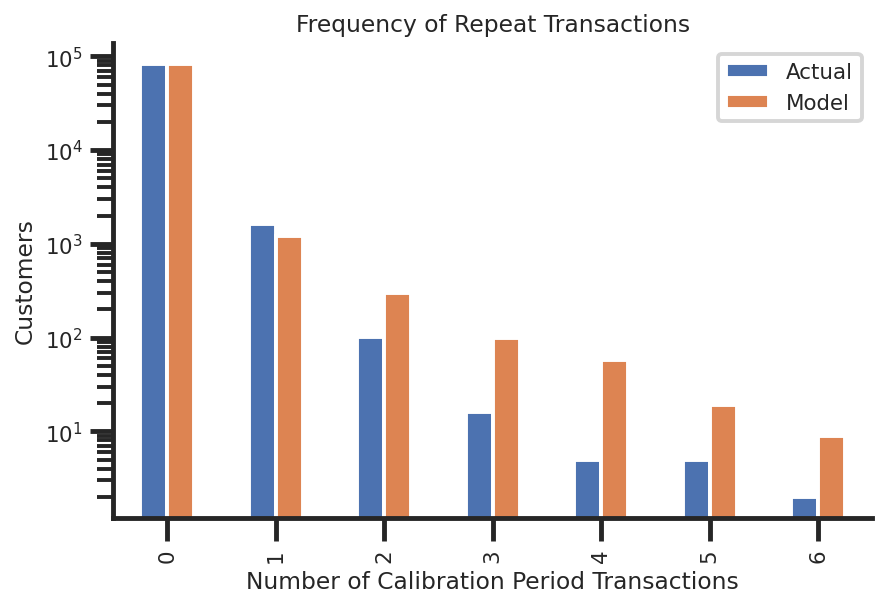

In [37]:
%%time

from lifetimes.plotting import plot_period_transactions
ax = plot_period_transactions(mbgnbd, max_frequency=7)
ax.set_yscale('log')
sns.despine()

CPU times: user 93.1 ms, sys: 2.83 ms, total: 95.9 ms
Wall time: 105 ms


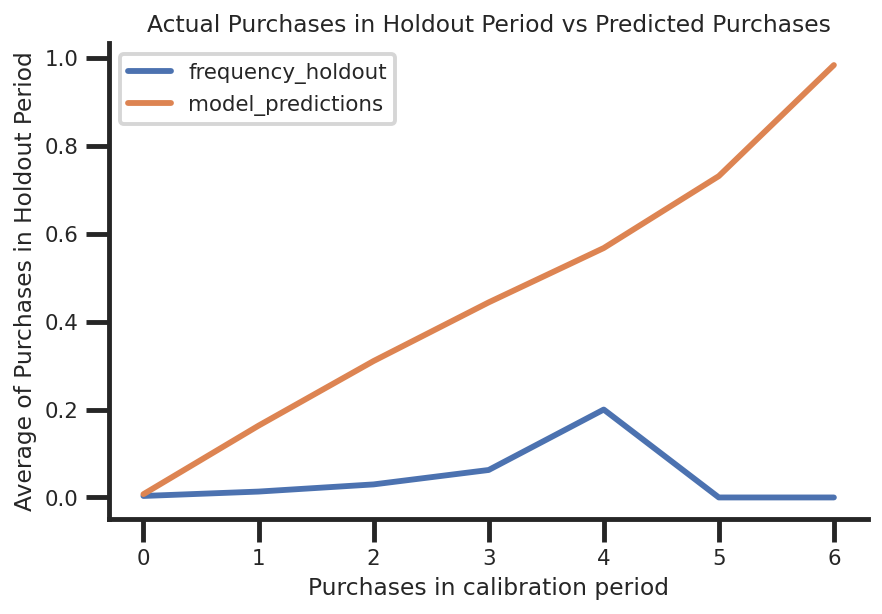

In [39]:
%%time

from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
plot_calibration_purchases_vs_holdout_purchases(mbgnbd, summary_cal_holdout)
sns.despine()

**Customer Probability History**

Peluang pelanggan masih ada hari ini adalah [0.3]


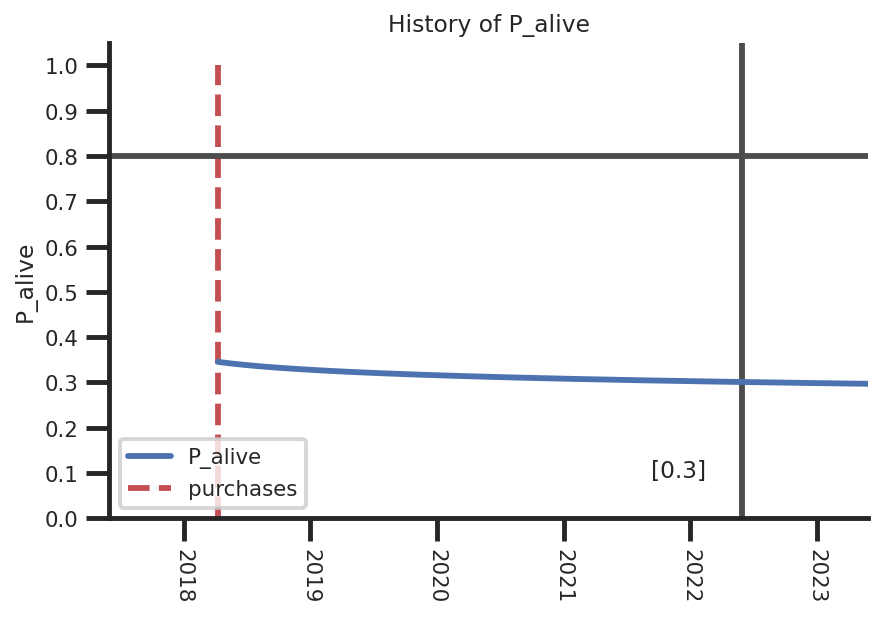

In [52]:
from os import P_ALL
from lifetimes.plotting import plot_history_alive
from datetime import date
from pylab import figure, text, scatter, sample

individual = summary_cal_holdout.iloc[4942]

id = individual.name
t = 365*50

today = date.today()
five_years_ago = today.replace(year=today.year - 5)
one_years_from_now = today.replace(year=today.year +1)

sp_trans = elog.loc[elog['CUSTOMER_ID'] == id]

from lifetimes.plotting import calculate_alive_path

t = (today - sp_trans.ORDER_DATE.min().date()).days
p_alive_today = pd.DataFrame(calculate_alive_path(mbgnbd, sp_trans, 'ORDER_DATE', t, freq='D'))[0].tail(1).values
p_alive_today = np.round(p_alive_today[0], 2)
print('Peluang pelanggan masih ada hari ini adalah', p_alive_today)

t = (one_years_from_now - sp_trans.ORDER_DATE.min().date()).days
ax = plot_history_alive(mbgnbd, t, sp_trans, 'ORDER_DATE', start_date=five_years_ago) #dimulai dari='2016-01-01'
ax.vlines(x=today, ymin=0, ymax=1.05, colors='#4C4C4C')
ax.hlines(y=0.8, xmin=five_years_ago, xmax=one_years_from_now, colors='#4C4C4C')

ax.set_xlim(five_years_ago, one_years_from_now) #sp_trans.ORDER_DATE.min()
ax.set_ylim(0, 1.05)

plt.xticks(rotation=-90)
text(0.75, 0.1, p_alive_today, ha='center', va='center', transform=ax.transAxes)
sns.despine()

**Predicted Transactions berdasarkan Time**

In [54]:
elog.columns = ['CUSTOMER_ID', 'date']

In [55]:
%%time
#Membuat transaksi kumulatif berulang yang diharapkan dan aktual

from lifetimes.utils import expected_cumulative_transactions

t = (elog.date.max()- elog.date.min()).days
df = expected_cumulative_transactions(mbgnbd, elog, 'date', 'CUSTOMER_ID', t)

CPU times: user 3.81 s, sys: 30.2 ms, total: 3.84 s
Wall time: 3.83 s


In [56]:
df.tail()

,actual,predicted
768,2383,3875.186570
769,2383,3888.104262
770,2383,3901.016511
771,2383,3913.923334
772,2384,3926.824743


CPU times: user 6.6 s, sys: 25.4 ms, total: 6.63 s
Wall time: 7.77 s


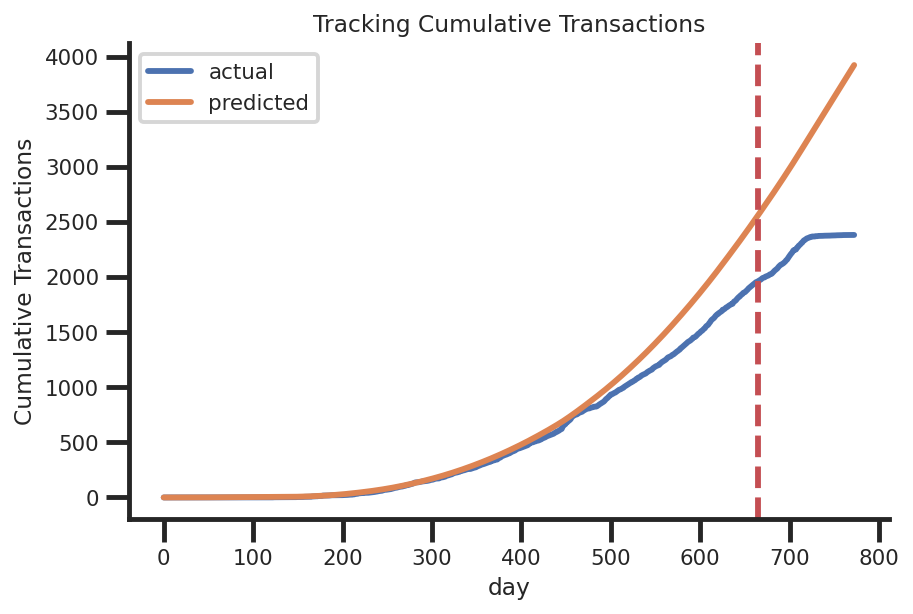

In [58]:
%%time
#calibration period = 2016-09-04 to 2017-09-30
from datetime import datetime

cal = datetime.strptime('2018-06-30', '%Y-%m-%d')

from lifetimes.plotting import plot_cumulative_transactions
t = (elog.date.max()- elog.date.min()).days
t_cal = (cal - elog.date.min()).days
plot_cumulative_transactions(mbgnbd, elog, 'date', 'CUSTOMER_ID', t, t_cal, freq='D')
sns.despine()

CPU times: user 5.72 s, sys: 18.7 ms, total: 5.74 s
Wall time: 5.97 s


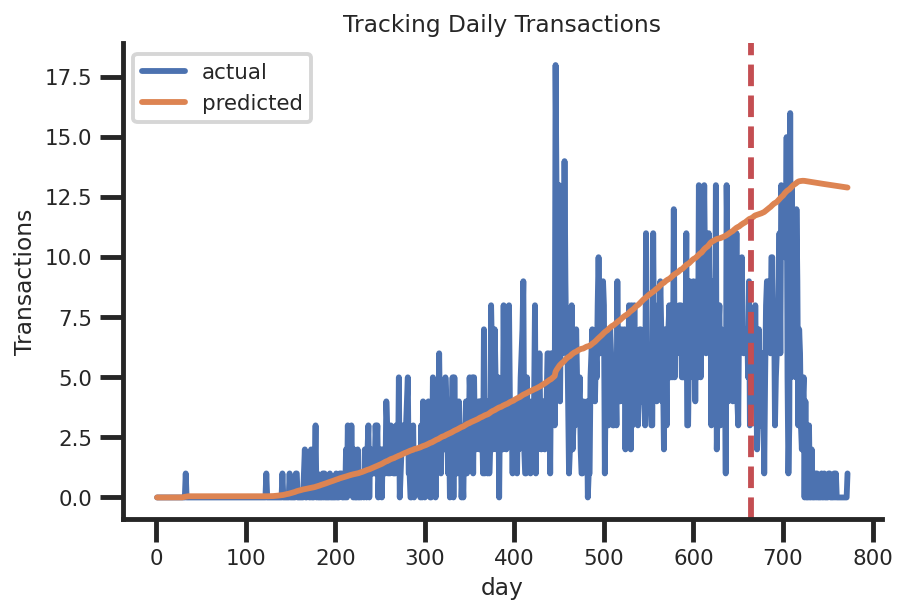

In [59]:
%%time

from lifetimes.plotting import plot_incremental_transactions
plot_incremental_transactions(mbgnbd, elog, 'date', 'CUSTOMER_ID', t, t_cal, freq='D')
sns.despine()

**Predict the conditional, expected average lifetime value of our customers**

In [61]:
#print("Expected conditional average revenue: €%s, Average revenue: €%s" % (
#    np.round(gg.conditional_expected_average_profit(
#        returning_customers_summary['frequency_cal'],
#        returning_customers_summary['monetary_value_cal']
#    ).mean(), 2),
#    np.round(returning_customers_summary[returning_customers_summary['frequency_cal']>0]['monetary_value_cal'].mean(), 2)
#))

**Performa model akan meningkat jika dilatih pada semua data dan bukan sampel seperti yang terjadi pada project ini**